## Simulation-Based Inference SIR Model: Training CDF
> Created: Mar 25 2024 Harrison B. Prosper and Ali Al Kadhim<br>

### Introduction
This notebook uses the training data $[\alpha, \beta, \lambda, \text{cdf}]$ to train a deep neural network to model the mapping $f: \lambda, \alpha, \beta \rightarrow \text{cdf}$.

In [1]:
import os, sys
sys.path.append('../')

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# pytorch
import torch
import torch.nn as nn

# split data into a training set and a test set
from sklearn.model_selection import train_test_split

# to reload modules
import importlib

# some simple dnn untilities
import dnnutil as dn

%matplotlib inline

device: cpu


In [2]:
# update fonts
FONTSIZE = 10
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 42
rnd  = np.random.RandomState(seed)

### Load training data

In [3]:
datafile = f'../../data/SIR_cdf_traindata.csv.gz'

print('loading %s' % datafile)
df  = pd.read_csv(datafile)
print('number of rows: %d\n' % len(df))

df[:5]

loading ../../data/SIR_cdf_traindata.csv.gz
number of rows: 45450



,point,alpha,beta,li,cdf
0,169,0.104930,0.344043,0.045702,0.57
1,354,0.590734,0.331966,0.060235,0.50
2,172,0.815682,0.423616,0.115661,0.83
3,40,0.299835,0.509103,0.049246,0.62
4,15,0.557782,0.663234,0.037941,0.51


### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and can be used, for example, to decide when to stop the training.

In [4]:
# Fraction of the data assigned as test data and validation
ntrain    = 35452                # training sample size
tfraction = (1-ntrain/len(df))/2 # test fraction
vfraction = tfraction            # validation fraction

# Split data into a part for training, validation, and testing
train_data, valid_data, test_data = dn.split_data(df, 
                                         test_fraction=tfraction, 
                                         validation_fraction=vfraction) 

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train_data[:5]

train set size:         35450
validation set size:     5000
test set size:           5000


,point,alpha,beta,li,cdf
0,372,0.579431,0.659799,0.015846,0.08
1,134,0.275850,0.452314,0.021259,0.18
2,18,0.861566,0.561222,0.359860,1.00
3,228,0.532811,0.424039,0.021763,0.12
4,349,0.890189,0.560416,0.049784,0.50


### Empirical risk (that is, average loss)

The empirical risk, which is the **objective function** we shall minimize, is defined by

\begin{align}
R_M(\omega) & = \frac{1}{M} \sum_{m=1}^{M} L(t_m, f_m),
\end{align}

where 

\begin{align*}
    f_m & \equiv f(\boldsymbol{x}_m, \omega)
\end{align*}
is the machine learning model with parameters $\omega$ to be determined by minimizing $R_M$. We shall fit the model $f$ for the cross section by minimizing the **weighted quadratic loss**

\begin{align}
    L(t, f) &= w (t - f)^2 ,
\end{align}
where $w$ is a suitably chosen weight. 

### Define model

In [46]:
%%writefile sircdf.py
import torch
import torch.nn as nn
import numpy as np

name     = 'sircdf'
features = ['alpha', 'beta', 'li']
target   = 'cdf'
nodes    = 15
nhidden  = 12
noutputs =  1

class ResNet(nn.Module):

    def __init__(self):
        # initial base class (nn.Module)
        super().__init__()
        self.NN = nn.Sequential(nn.Linear(nodes, nodes), nn.ReLU(),
                                nn.Linear(nodes, nodes), nn.ReLU())    
    def forward(self, x):
        return x + self.NN(x)
        
class SIRNet(nn.Module):

    def __init__(self):

        # initial base class (nn.Module)
        super().__init__()
        
        cmd = 'self.NN = nn.Sequential('\
        'nn.Linear(len(features), nodes), nn.ReLU(), '\
        'nn.Linear(nodes, nodes), nn.ReLU(),'
        
        for _ in range(nhidden):
            cmd += 'ResNet(),'
            
        cmd += 'nn.Linear(nodes, noutputs), nn.Sigmoid())'
        
        exec(cmd)
        
    def forward(self, x):
        return self.NN(x)

Overwriting sircdf.py


In [60]:
import sircdf as NN
importlib.reload(NN)

name     = NN.name
model    = NN.SIRNet()
features = NN.features
target   = NN.target

modelfile  = '%s.dict' % NN.name
print(name)
print(model)
print('number of parameters: %d\n' % dn.number_of_parameters(model))

# check model
X = torch.Tensor(test_data[['li','alpha', 'beta']].to_numpy())
print('input.size:  ', X.size())

Y = model(X)
print('output.size: ', Y.size())

sircdf
SIRNet(
  (NN): Sequential(
    (0): Linear(in_features=3, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): ReLU()
    (4): ResNet(
      (NN): Sequential(
        (0): Linear(in_features=15, out_features=15, bias=True)
        (1): ReLU()
        (2): Linear(in_features=15, out_features=15, bias=True)
        (3): ReLU()
      )
    )
    (5): ResNet(
      (NN): Sequential(
        (0): Linear(in_features=15, out_features=15, bias=True)
        (1): ReLU()
        (2): Linear(in_features=15, out_features=15, bias=True)
        (3): ReLU()
      )
    )
    (6): ResNet(
      (NN): Sequential(
        (0): Linear(in_features=15, out_features=15, bias=True)
        (1): ReLU()
        (2): Linear(in_features=15, out_features=15, bias=True)
        (3): ReLU()
      )
    )
    (7): ResNet(
      (NN): Sequential(
        (0): Linear(in_features=15, out_features=15, bias=True)
        (1): ReLU()
        (2): Linear(

### Weighted quadratic loss

In [51]:
def average_quadratic_loss_weighted(f, t, x=None):
    # f and t must be of the same shape
    li = x[:,0]
    #w = torch.where(t != 0, 1/torch.abs(t), 1)
    w = torch.where(li < 0.05, 5, 1)
    return  torch.mean(w * (f - t)**2)

### Train!

In [61]:
traces = ([], [], [])

In [62]:
traces_step   = 100
n_batch       = 128
n_iterations  = 5000000
early_stopping= 250000
learning_rate = 4.e-4

Iteration vs average loss
iteration train-set valid-set
945200200 0.0001661 0.0001883    945100:    695100/0.00017985/   250000

stopping early!



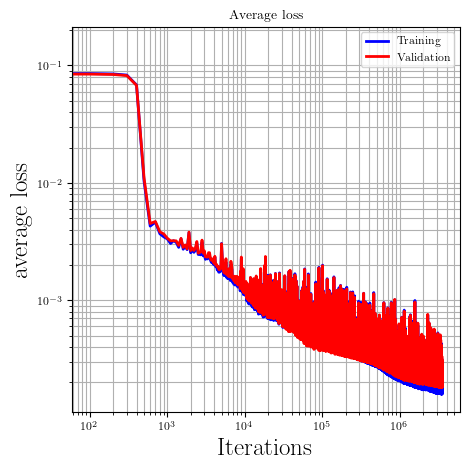

In [74]:
av_loss = dn.average_quadratic_loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

traces = dn.train(model, optimizer, 
                  modelfile, early_stopping,
                  av_loss,
                  dn.get_batch, 
                  train_data, valid_data,
                  features, target,
                  n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step)

dn.plot_average_loss(traces)

### Apply trained model to test data

In [75]:
Load_lowest_loss_model = True

if Load_lowest_loss_model:
    print('load lowest loss model dictionary: %s' % modelfile)
    modeldict = torch.load(modelfile)
    model = NN.SIRNet()
    model.load_state_dict(modeldict)

# NN-approximated cdf
model.eval()
y = model(X).detach().numpy()

# empirical cdf
t = test_data['cdf'].to_numpy()

load lowest loss model dictionary: sircdf.dict


### Plot NN prediction vs. predicted cross section

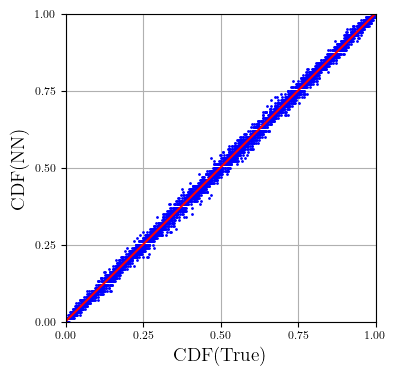

In [76]:
def plot_results(y, t, 
                 xmin=0.0, xmax=1.0, 
                 ymin=0.0, ymax=1.0, 
                 ftsize=14, 
                 filename='../../images/fig_SIR_results.png'):

    # create an empty figure
    fig = plt.figure(figsize=(4, 4))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows, ncols, index)
    
    ticks = np.linspace(xmin, xmax, 5)
    
    ax.set_xlim(xmin, xmax)
    ax.set_xticks(ticks)
    ax.set_xlabel(r'CDF(True)', fontsize=ftsize)

    ax.set_ylim(ymin, ymax)
    ax.set_yticks(ticks)
    ax.set_ylabel(r'CDF(NN)', fontsize=ftsize)
    
    ax.plot(y, t, 'b', marker='.', markersize=2, linestyle='')
    ax.plot([xmin, xmax], [ymin, ymax], linestyle='solid', color='red')

    ax.grid(True, which="both", linestyle='-')

    plt.savefig(filename)
    plt.show()

plot_results(y, t)

### Plot CDF
  1. Load cdf data

In [57]:
cdf = pd.read_csv('../../data/SIR_data.csv.gz', nrows=50)
cdf[:5]

,alpha,beta,I,li
0,0.556824,0.432547,"[3.0000e+00,2.5413e+01,6.6242e+01,1.4076e+02,2...","[1.4328e-01,1.5793e-02,2.0244e-02,6.4930e-02,1..."
1,0.917183,0.617733,"[3.0000e+00,4.6435e+01,1.2668e+02,1.8865e+02,1...","[2.5709e-02,4.3687e-02,6.9471e-02,7.0595e-02,2..."
2,0.222595,0.684092,"[3.0000e+00,2.3207e+02,5.2139e+02,5.1127e+02,4...","[3.5421e-02,2.6438e-02,4.9833e-02,2.0407e-02,6..."
3,0.513685,0.231400,"[3.0000e+00,6.2250e+00,8.8920e+00,1.2593e+01,1...","[3.4936e-02,3.1336e-02,1.0310e-01,3.5408e-02,1..."
4,0.533168,0.343659,"[3.0000e+00,1.3872e+01,2.8699e+01,5.5722e+01,9...","[5.8801e-02,3.4601e-02,4.5421e-02,1.5795e-01,6..."


In [71]:
def get_cdf(model, df, row, n=51):

    alpha, beta, li = df[['alpha', 'beta', 'li']].iloc[row]
    li = eval(li)

    # true mapping between cdf and test statistic
    cdftrue = np.linspace(0, 1, n)
    li = np.quantile(li, cdftrue)

    # compute approximated cdf
    model.eval()
    inputs = torch.Tensor(np.array([[x, alpha, beta] for x in li]))
    cdfnn  = model(inputs).view(-1).detach().numpy()

    return li, cdftrue, cdfnn, alpha, beta

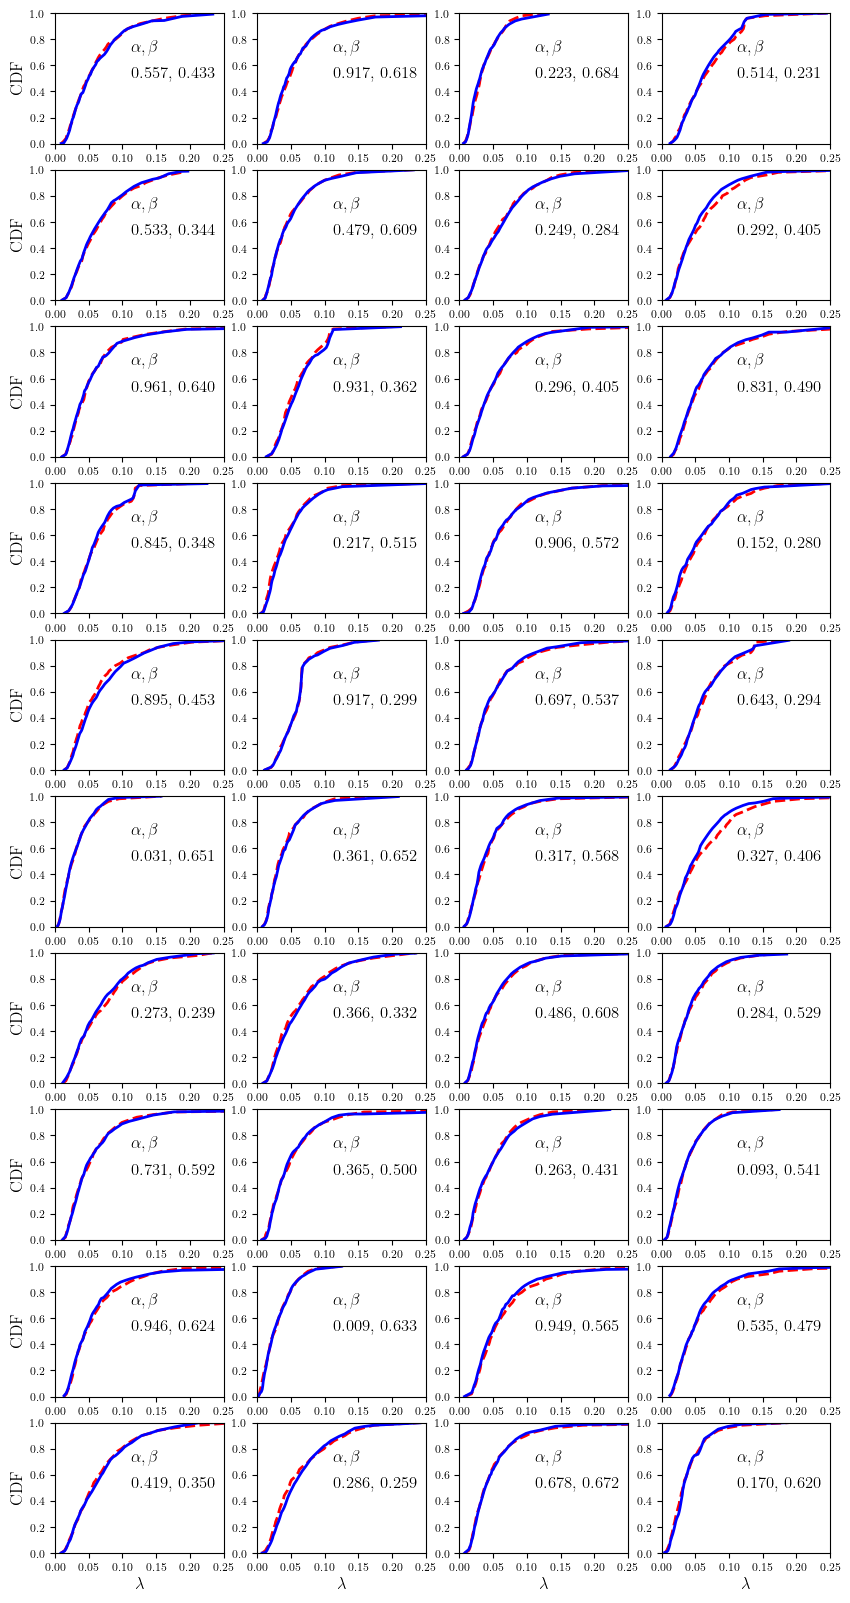

In [77]:
def plot_cdf(data, 
                 ftsize=12, 
                 filename='fig_cdf_comparisons.png'):

    plt.rcParams.update({'font.size': 8})
    
    xmin, ymin = 0, 0
    xmax, ymax = 0.25, 1

    # create an empty figure
    fig = plt.figure(figsize=(10, 20))
    fig.tight_layout()

    # work out number of columns and number of plots
    ncols = 4
    nrows = len(data) // ncols
    ndata = nrows * ncols

    # loop over coefficients

    for i, (li, cdftrue, cdfnn, alpha, beta) in enumerate(data):

        index = i+1
        ax  = fig.add_subplot(nrows, ncols, index)

        # setup x-axis
        ax.set_xlim(xmin, xmax)
        
        if i > (nrows-1) * ncols-1:
            ax.set_xlabel(r'$\lambda$', fontsize=ftsize)

        # setup y-axis
        ax.set_ylim(ymin, ymax)
        
        if i % ncols == 0:
            ax.set_ylabel(r'CDF', fontsize=ftsize)

        # annotate plot
        xpos = xmin + 0.45 * (xmax-xmin)
        ypos = ymin + 0.70 * (ymax-ymin)
        ystep= (ymax-ymin)/5
        ax.text(xpos, ypos, r'$\alpha, \beta$', fontsize=ftsize); ypos -= ystep
        ax.text(xpos, ypos, '%6.3f,%6.3f' % (alpha, beta), fontsize=ftsize)
        
        # True cdf
        ax.plot(li, cdftrue, color='red', linestyle='dashed', linewidth=2)

        # NN-approximated cdf
        ax.plot(li, cdfnn, color='blue', linewidth=2)

    plt.savefig(filename)
    plt.show()
# ------------------------------------------------------------------
M = 40
data = []
for row in range(M):
    data.append( get_cdf(model, cdf, row) )
plot_cdf(data)

In [78]:
li, cdftrue, cdfnn, alpha, beta = data[0]
y = np.where(cdfnn > 0, cdftrue / cdfnn, 1)
cdftrue.shape, cdfnn.shape

((51,), (51,))

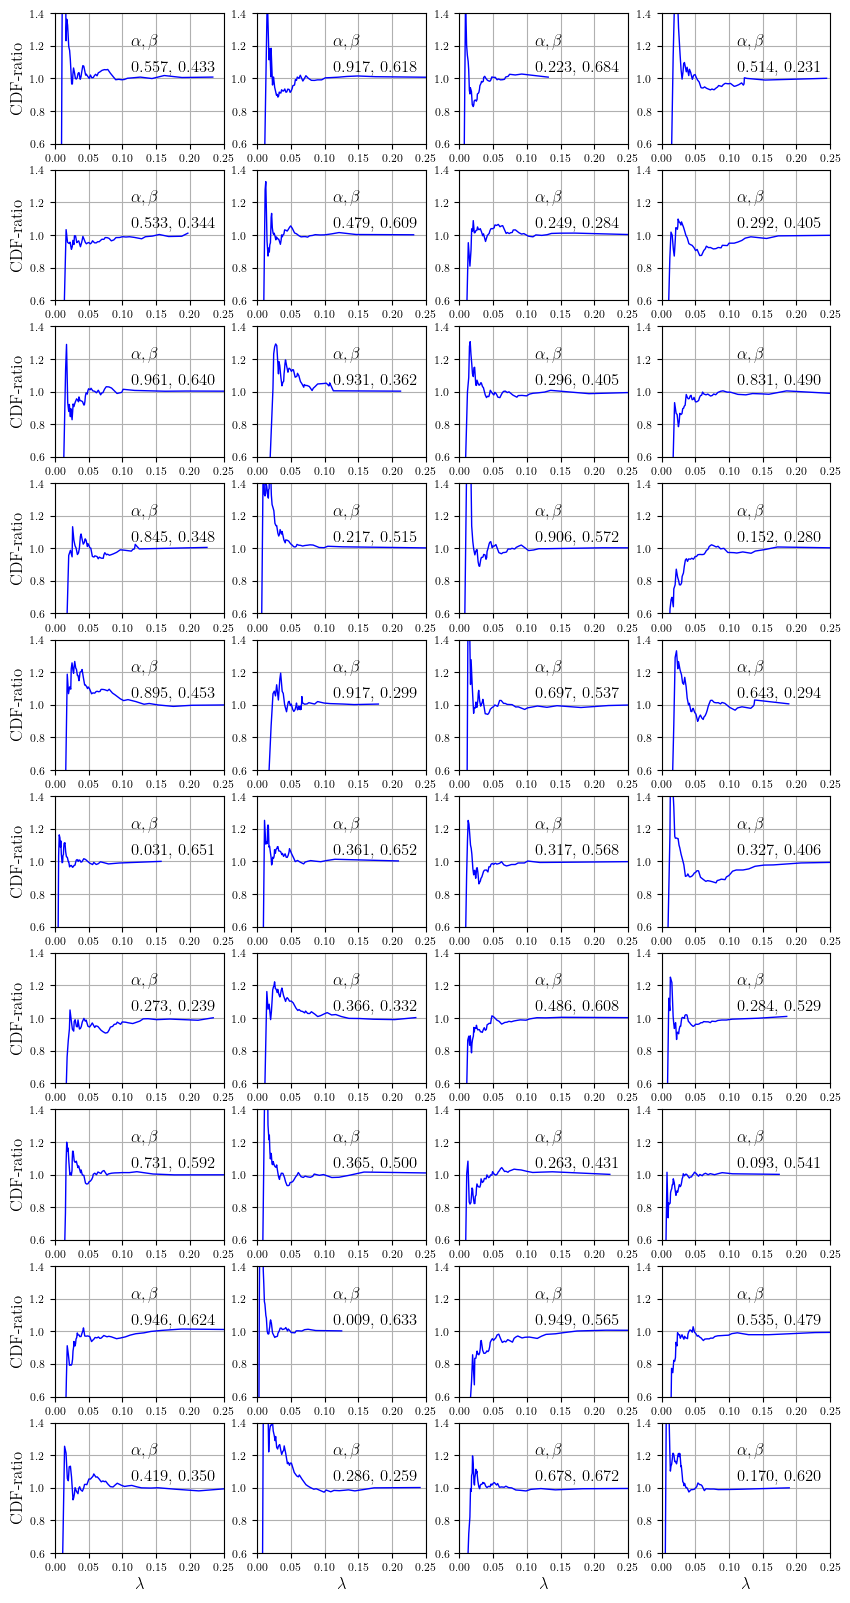

In [79]:
def plot_cdf_ratio(data, 
                 ftsize=12, 
                 filename='fig_cdf_comparisons_ratio.png'):

    plt.rcParams.update({'font.size': 8})
    
    xmin, ymin = 0, 0.6
    xmax, ymax = 0.25, 1.4

    # create an empty figure
    fig = plt.figure(figsize=(10, 20))
    fig.tight_layout()

    # work out number of columns and number of plots
    ncols = 4
    nrows = len(data) // ncols
    ndata = nrows * ncols

    # loop over coefficients

    for i, (li, cdftrue, cdfnn, alpha, beta) in enumerate(data):

        index = i+1
        ax  = fig.add_subplot(nrows, ncols, index)

        # setup x-axis
        ax.set_xlim(xmin, xmax)
        
        if i > (nrows-1) * ncols-1:
            ax.set_xlabel(r'$\lambda$', fontsize=ftsize)

        # setup y-axis
        ax.set_ylim(ymin, ymax)
        
        if i % ncols == 0:
            ax.set_ylabel(r'CDF-ratio', fontsize=ftsize)

        # annotate plot
        xpos = xmin + 0.45 * (xmax-xmin)
        ypos = ymin + 0.75 * (ymax-ymin)
        ystep= (ymax-ymin)/5
        ax.text(xpos, ypos, r'$\alpha, \beta$', fontsize=ftsize); ypos -= ystep
        ax.text(xpos, ypos, '%6.3f,%6.3f' % (alpha, beta), fontsize=ftsize)
        
        # cdf-ratio
        y = np.where(cdfnn > 0, cdftrue / cdfnn, 1)
        ax.plot(li, y, color='blue', linewidth=1)
        ax.grid(True, which="both", linestyle='-')
        
    plt.savefig(filename)
    plt.show()
# ------------------------------------------------------------------
plot_cdf_ratio(data)